In [1]:
import pandas as pd

data = pd.read_csv("final_data_to_train.csv")
filtered_data_id5 = data[data['sourceId'] == 5]

filtered_data_id5.head()

,meterId,sourceId,totalVehicles,provinceId,municipalityId,latitude,longitude,year,month,day,hour,minute
1433928,489,5,0,48,20,43.263880,-2.929052,2022,4,13,23,0
1433929,490,5,168,48,20,43.261185,-2.946759,2022,4,13,23,0
1433930,491,5,168,48,20,43.262466,-2.946243,2022,4,13,23,0
1433931,492,5,0,48,20,43.263866,-2.945667,2022,4,13,23,0
1433932,493,5,175,48,20,43.264891,-2.945473,2022,4,13,23,0


In [2]:
filtered_data_id5 = filtered_data_id5.dropna()
filtered_data_id5.head()

,meterId,sourceId,totalVehicles,provinceId,municipalityId,latitude,longitude,year,month,day,hour,minute
1433928,489,5,0,48,20,43.263880,-2.929052,2022,4,13,23,0
1433929,490,5,168,48,20,43.261185,-2.946759,2022,4,13,23,0
1433930,491,5,168,48,20,43.262466,-2.946243,2022,4,13,23,0
1433931,492,5,0,48,20,43.263866,-2.945667,2022,4,13,23,0
1433932,493,5,175,48,20,43.264891,-2.945473,2022,4,13,23,0


In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import xgboost as xgb

X = filtered_data_id5.drop(columns=['totalVehicles', 'sourceId', 'provinceId'])
y = filtered_data_id5['totalVehicles']

numerical_vars = ['meterId','municipalityId','latitude','longitude','year','month','day', 'hour', 'minute']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer(
    transformers = [('num', StandardScaler(), numerical_vars)]
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(learning_rate=0.1, max_depth=15, n_estimators=200))
])

print('Done')

Done


In [4]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

pipeline.fit(X_train,y_train)

# Make predictions on the test data
y_pred = pipeline.predict(X_test)

# Calculate evaluation scores
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation scores
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared Score (R2):", r2)

Mean Squared Error (MSE): 83572.8320206717
Mean Absolute Error (MAE): 109.17421793186375
R-squared Score (R2): 0.770775488738656


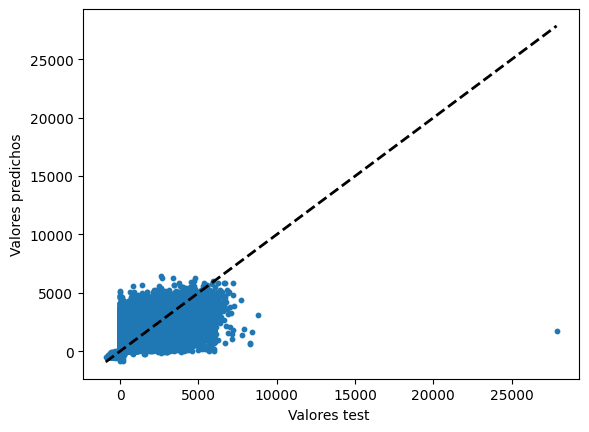

In [5]:
import matplotlib.pyplot as plt

# Plotting predicted values vs. test values
plt.scatter(y_test, y_pred, s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Plotting the diagonal line
plt.xlabel('Valores test ')
plt.ylabel('Valores predichos')
plt.show()

In [6]:
predicted_data = X_test[['meterId','latitude', 'longitude', 'month']].copy()
predicted_data['PredictedValues'] = y_pred  # Assuming y_pred contains the predicted values
predicted_data.reset_index(drop=True, inplace=True)

new_df = predicted_data.groupby('meterId').agg({'latitude': 'first', 'longitude': 'first', 'month': 'first', 'PredictedValues': 'sum'}).reset_index()
new_df.head()
new_df.dropna(inplace=True)

# Filter predicted_data for month 6
predicted_data_month5 = predicted_data[predicted_data['month'] == 6]
print(predicted_data_month5['PredictedValues'].max())
print(predicted_data_month5['PredictedValues'].min())
predicted_data_month5['PredictedValues'] = predicted_data_month5['PredictedValues'].clip(lower=1)
print(predicted_data_month5['PredictedValues'].min())

6480.868
-676.2918
1.0


/var/folders/gh/yt97y6vj0_79f2lwfvsdnjpw0000gn/T/ipykernel_25234/153920253.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicted_data_month5['PredictedValues'] = predicted_data_month5['PredictedValues'].clip(lower=1)


In [23]:
import plotly.graph_objects as go
from plotly.offline import plot

scaling_factor = 0.05

fig = go.Figure(go.Densitymapbox(
    lat=predicted_data_month5['latitude'],
    lon=predicted_data_month5['longitude'],
    z=predicted_data_month5['PredictedValues']*scaling_factor,
    radius=predicted_data_month5['PredictedValues']*scaling_factor+1,  # Increase the radius value to make the dots bigger
    colorscale = 'YlOrRd',
    opacity=0.75,
    showscale=False
))

fig.update_layout(mapbox_style="stamen-terrain")
fig.update_layout(
    margin={"r": 0, "t": 0, "l": 0, "b": 0},
    mapbox_center={"lat": 43.2532, "lon": -2.9240},  # Set the center coordinates to Vitoria/Gasteiz
    mapbox_zoom=13.5, # Adjust the zoom level as desired

)

# Generate an HTML file with the plot
plot(fig, filename='density_map_id5_month6.html')

'density_map_id5_month6.html'

In [22]:
new_df.to_csv('predictions/predicted_data_id5_2022.csv', index=False)